# EDA 
after preparing the basic data, some advance EDA, and feature extraction/creation

### 0. Importing necessary Libraries

In [1]:
import gc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
DATA_FOLDER = '../data/'
import utils

### 1. Read the last saved file

In [2]:
%%time
df_sales = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_by_day_cleaned.csv'))
df_test  = pd.read_csv(os.path.join(DATA_FOLDER, 'test_data_cleaned.csv'))

sales_util = utils.SalesUtils('../submissions/')

Wall time: 7.37 s


In [3]:
len_sales = len(df_sales) 
len_test = len(df_test)

In [4]:
df_sales.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,weekday,weekdayno,year,item_category_id,parent_cat_id,parent_cat,city_id,city_name,is_holiday,revenue
2588871,2015-10-28,33,55,1819,1499.0,3,28,10,Wednesday,2,2015,31,15,pc games,3,Digital,0,4497.0
2588872,2015-10-29,33,55,1819,1499.0,1,29,10,Thursday,3,2015,31,15,pc games,3,Digital,1,1499.0
2588873,2015-10-24,33,55,2390,99.0,1,24,10,Saturday,5,2015,31,15,pc games,3,Digital,1,99.0
2588874,2015-10-01,33,55,1935,249.0,1,1,10,Thursday,3,2015,31,15,pc games,3,Digital,1,249.0
2588875,2015-10-17,33,55,2066,199.0,1,17,10,Saturday,5,2015,31,15,pc games,3,Digital,0,199.0


In [5]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,weekday,weekdayno,year,item_category_id,parent_cat_id,parent_cat,city_id,city_name,is_holiday,revenue
0,2013-01-02,0,59,22154,999.0,1,2,1,Wednesday,2,2013,37,6,cinema,29,Yaroslavl,0,999.0
1,2013-05-16,4,59,2573,249.0,1,16,5,Thursday,3,2013,55,13,music,29,Yaroslavl,0,249.0
2,2013-01-26,0,59,2574,399.0,1,26,1,Saturday,5,2013,55,13,music,29,Yaroslavl,0,399.0
3,2013-01-09,0,59,2574,399.0,1,9,1,Wednesday,2,2013,55,13,music,29,Yaroslavl,0,399.0
4,2013-02-24,1,59,2574,399.0,1,24,2,Sunday,6,2013,55,13,music,29,Yaroslavl,0,399.0


### 2. Checking for Holiday Sales against non holiday sales in a particular month

##### for all years and months

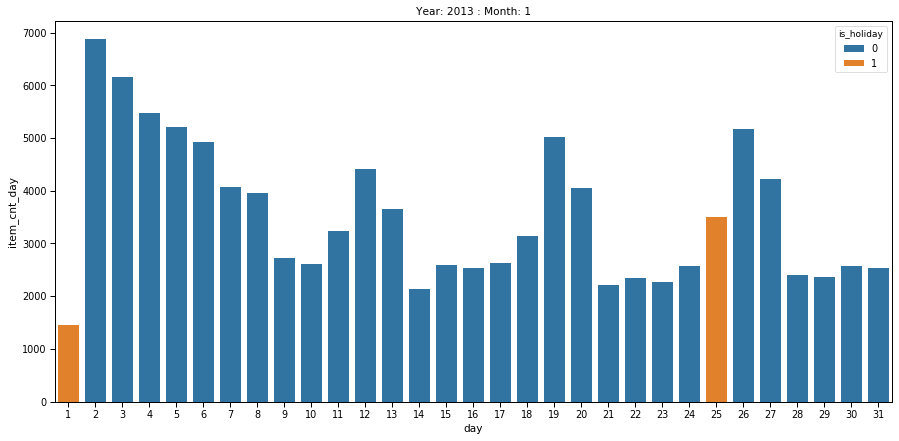

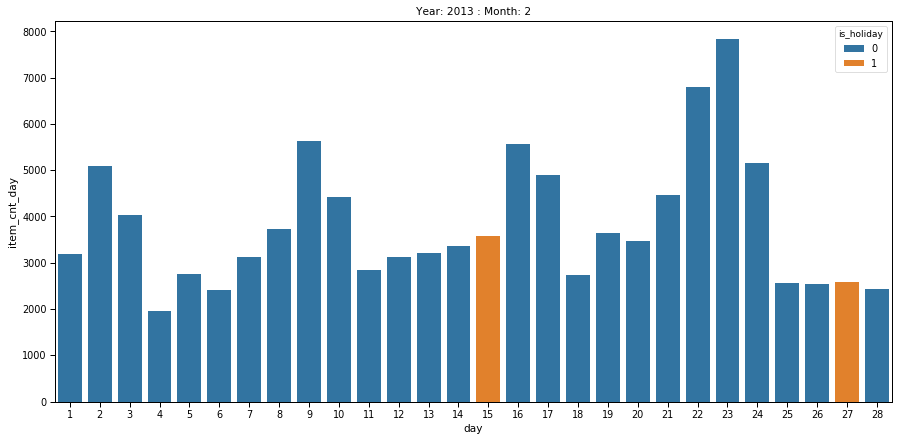

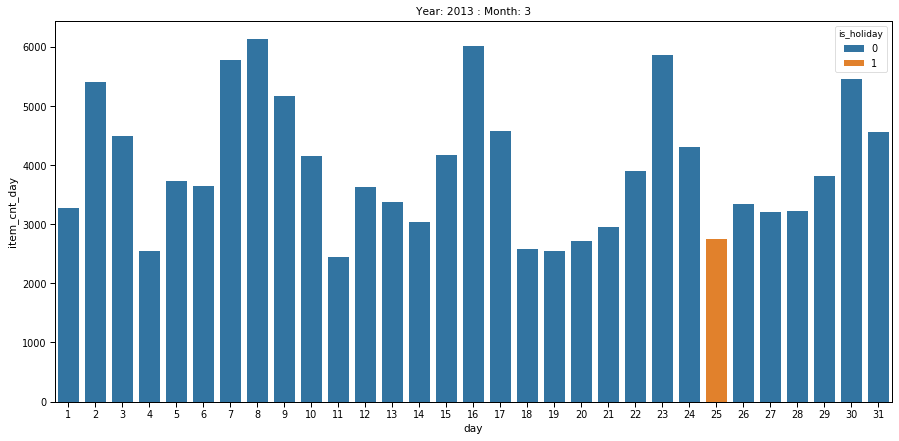

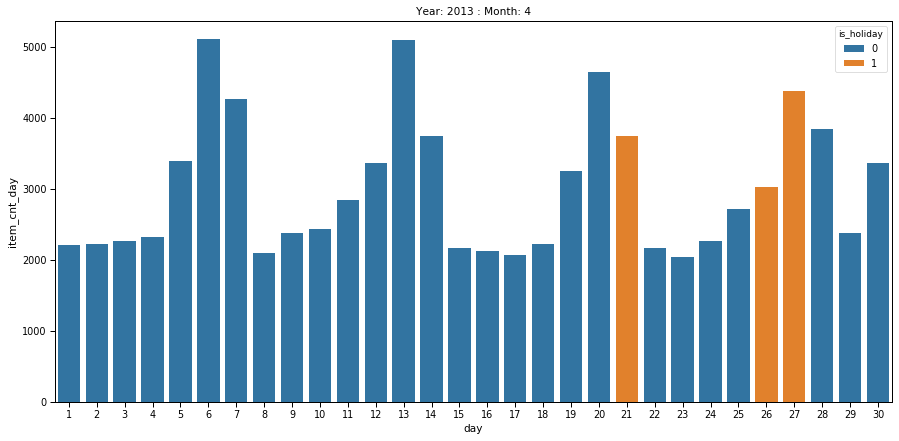

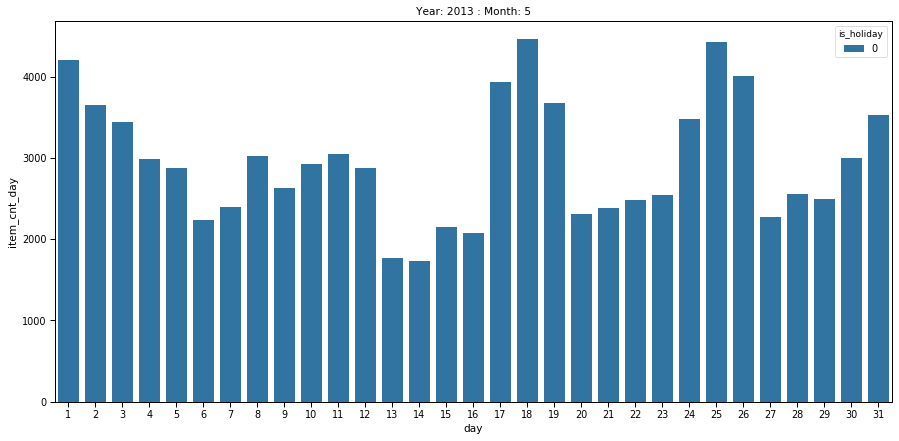

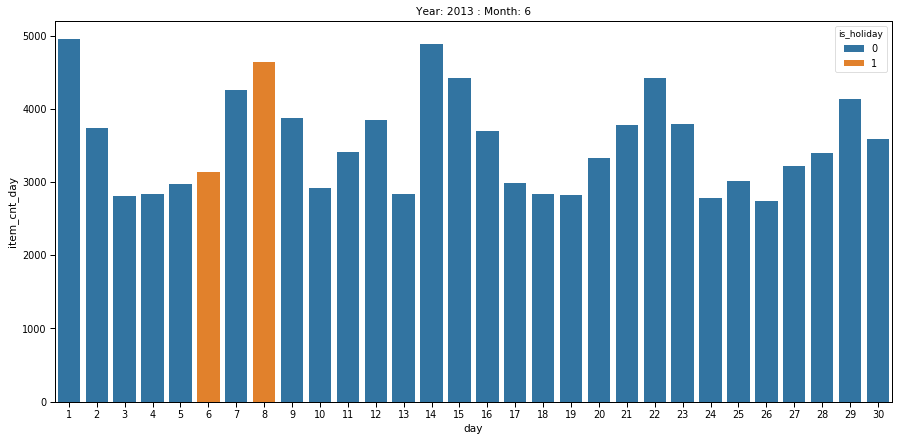

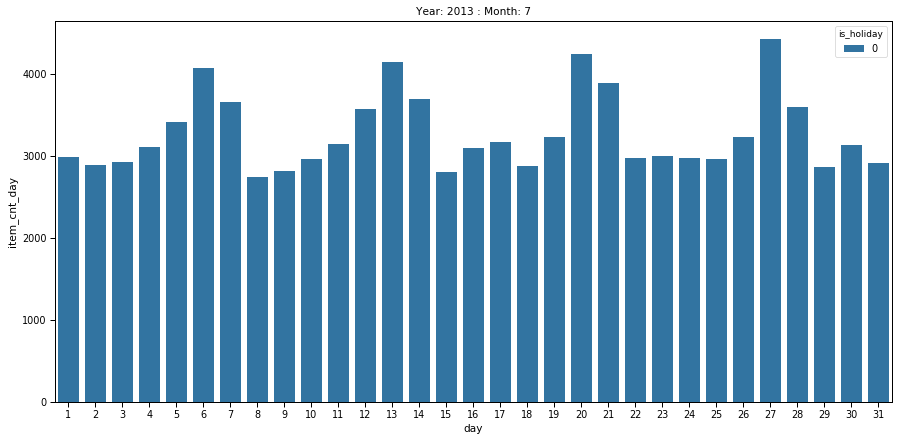

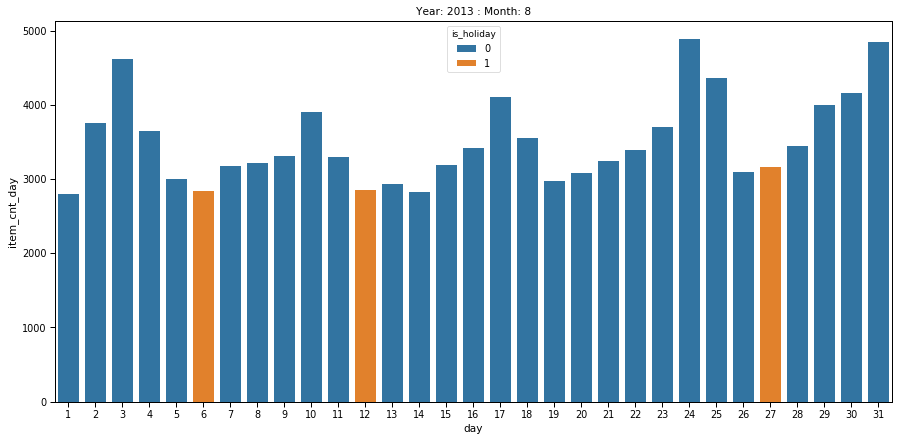

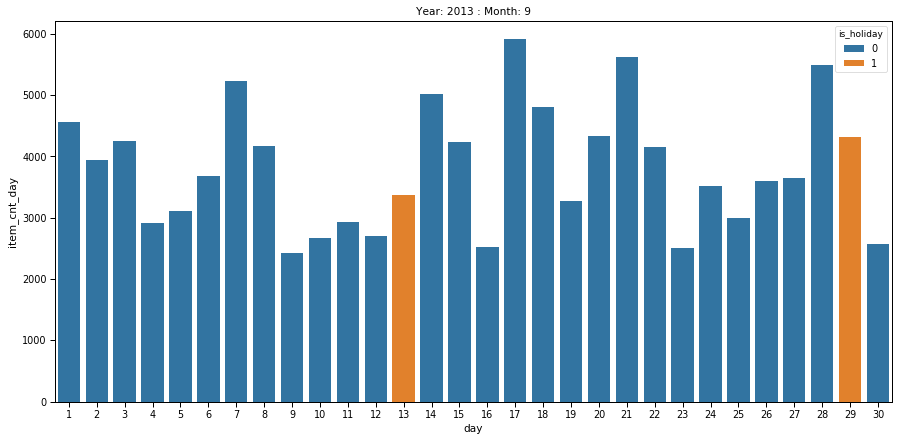

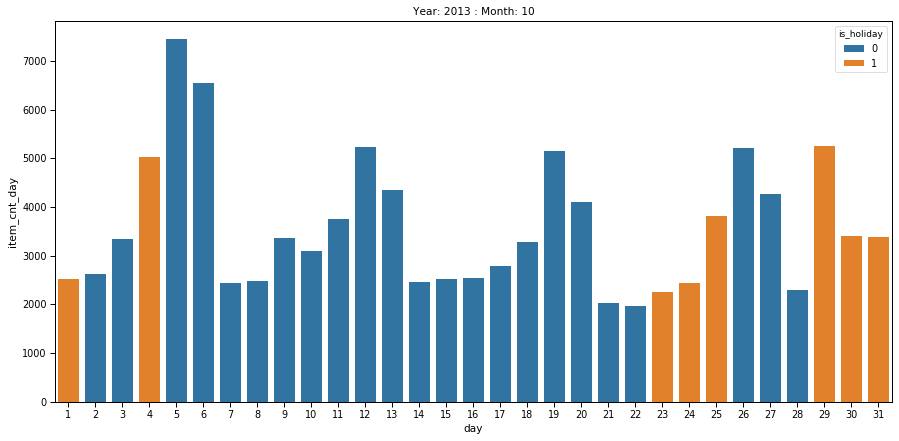

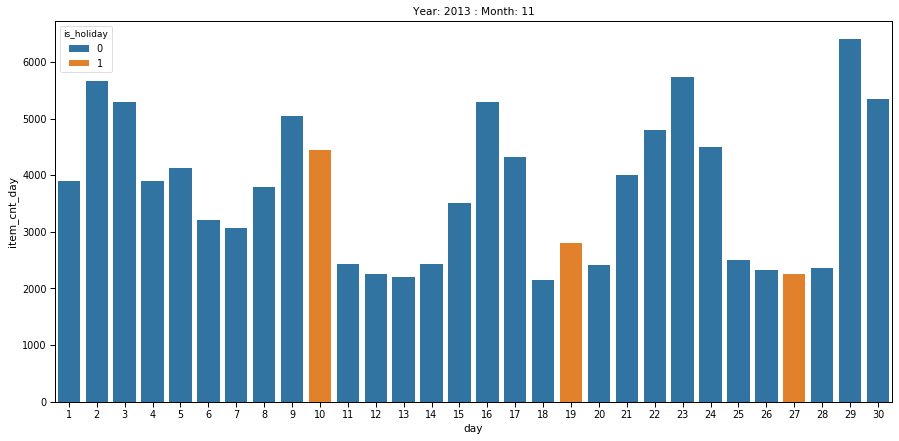

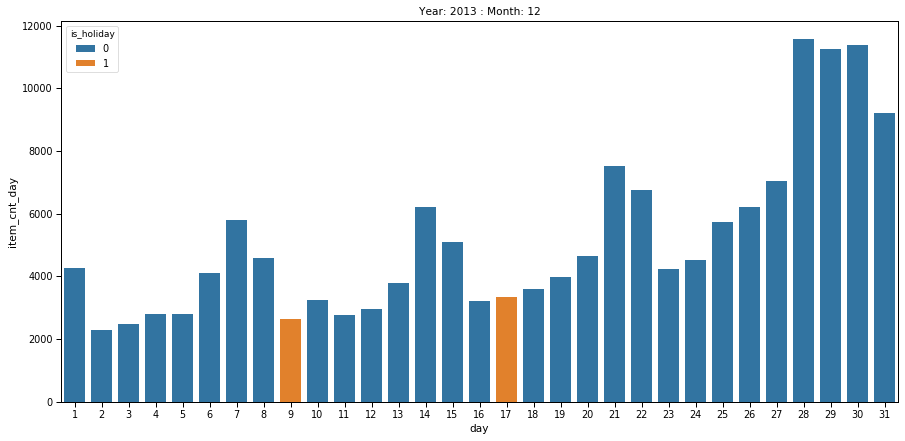

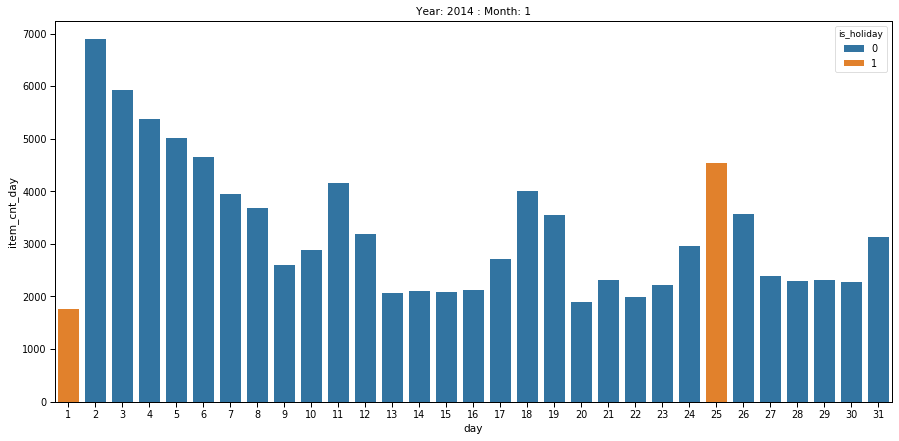

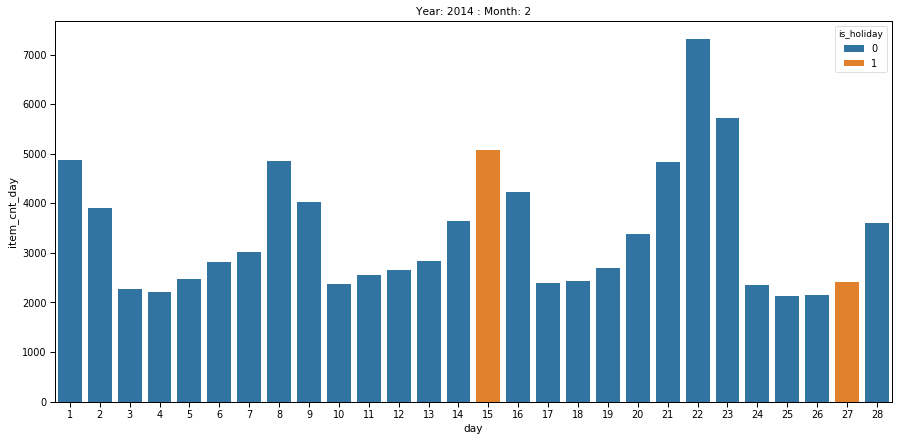

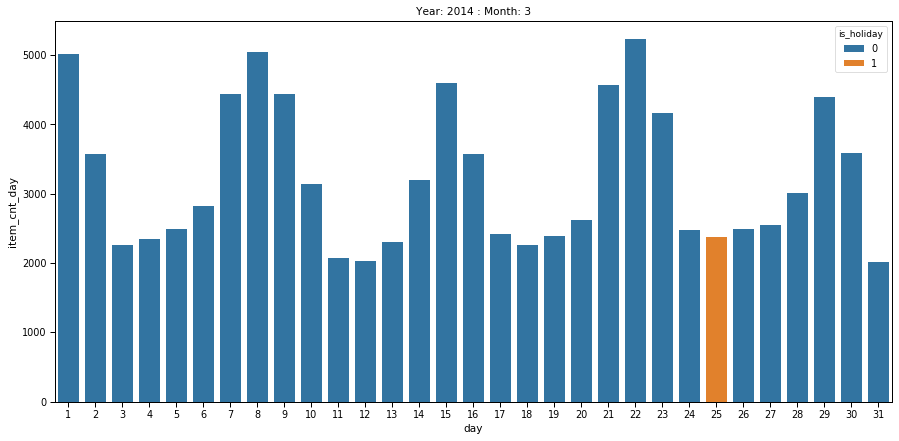

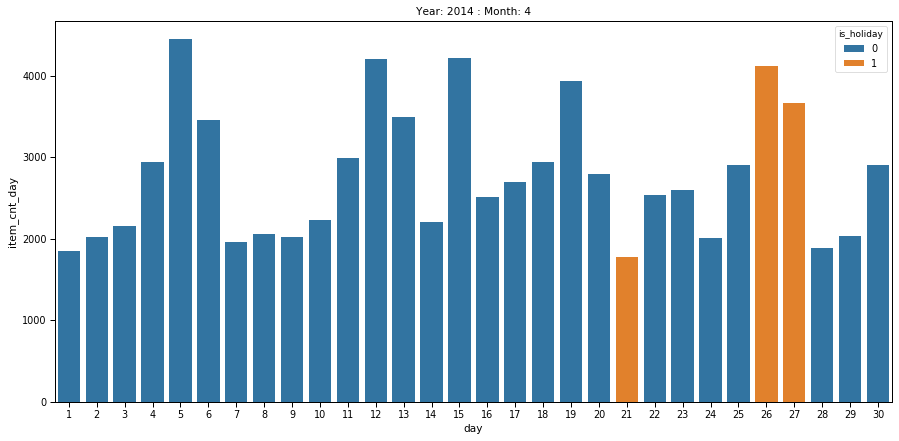

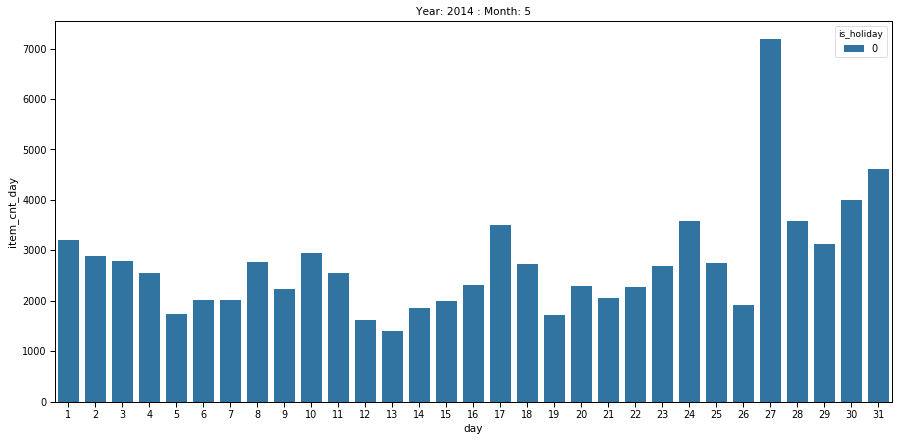

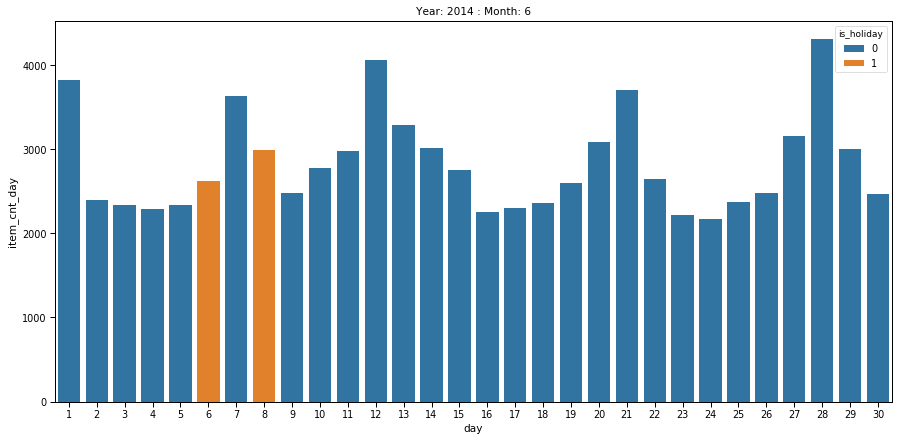

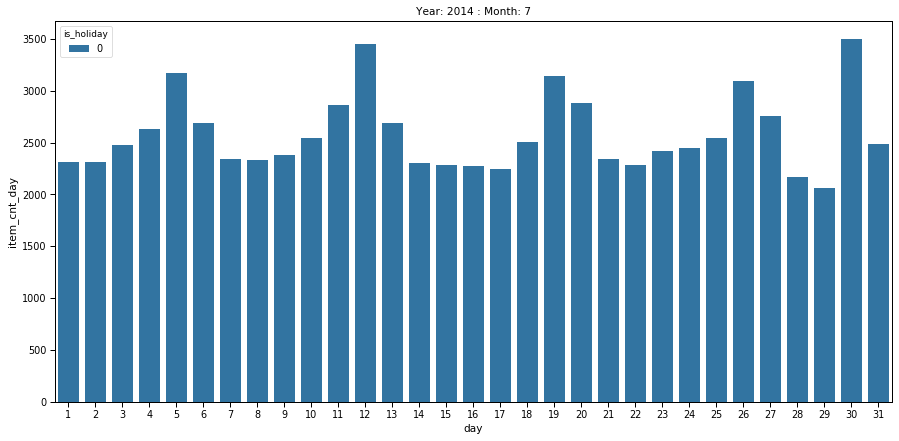

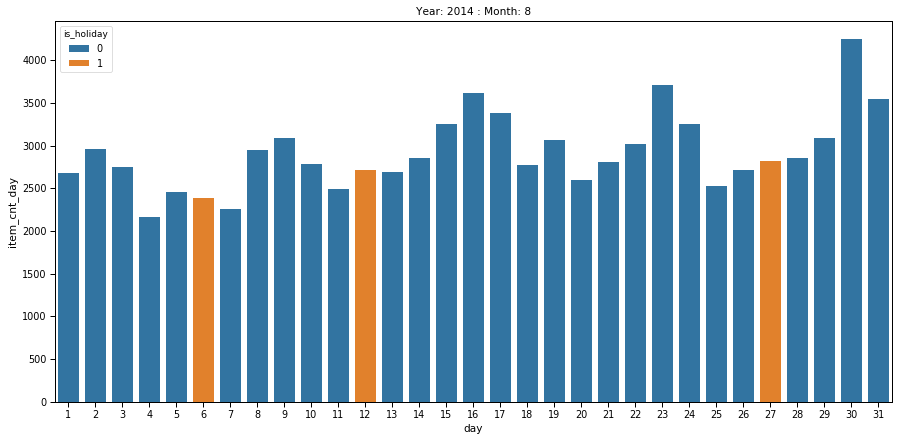

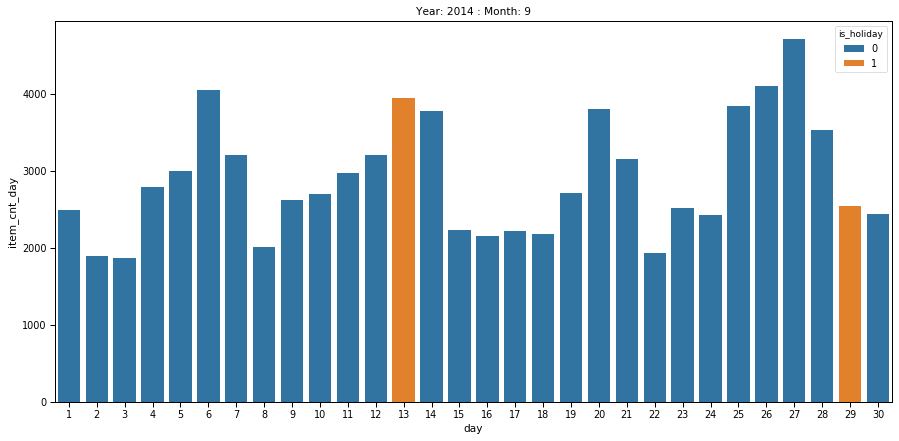

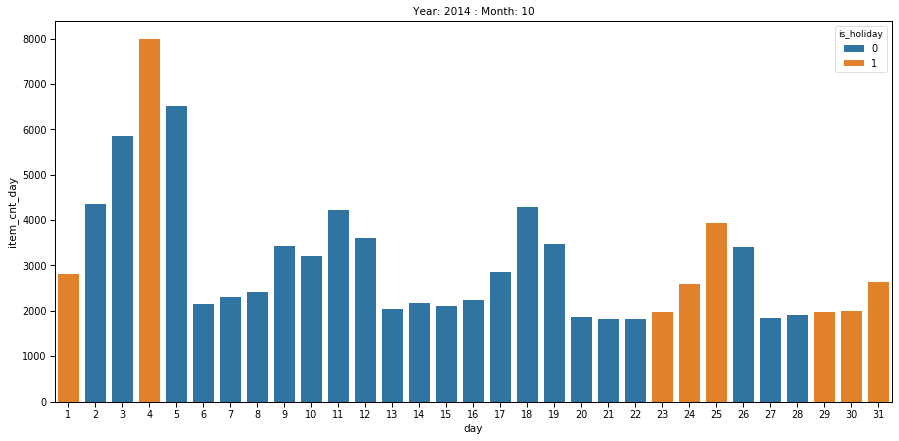

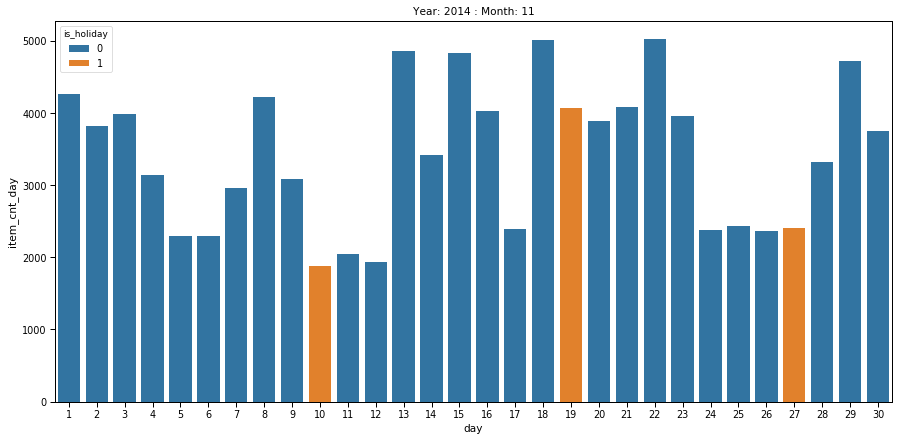

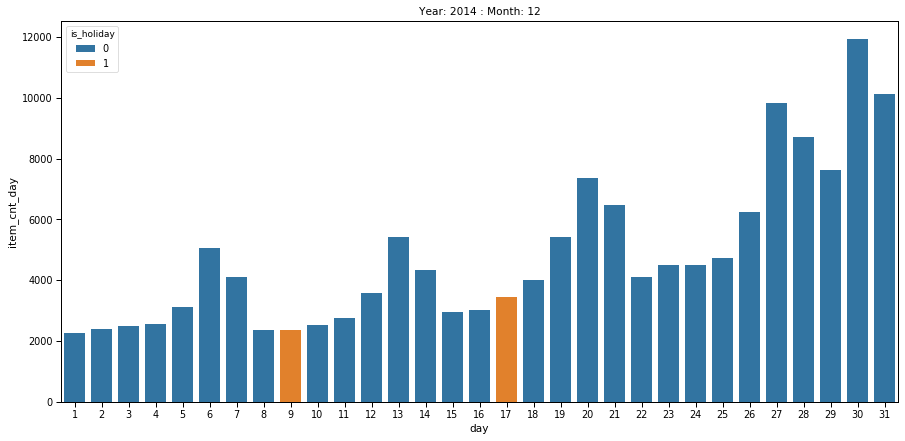

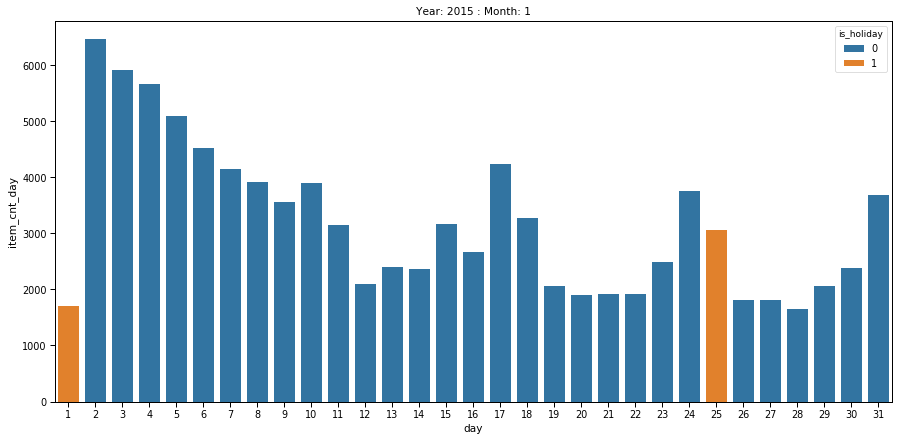

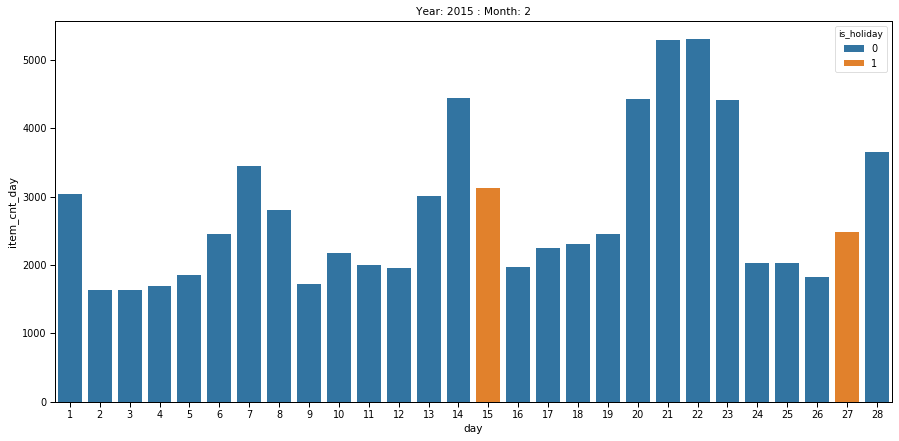

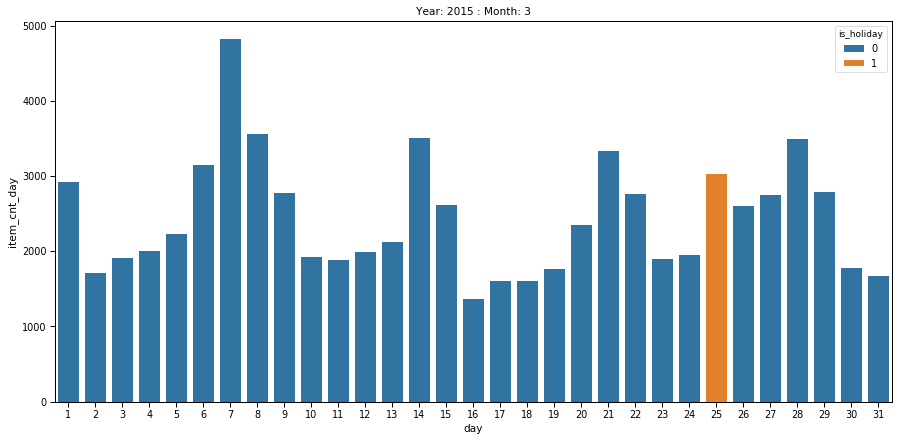

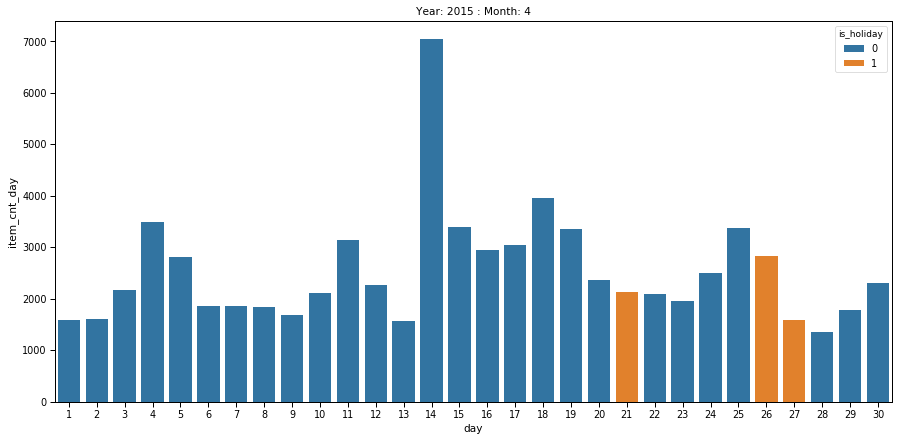

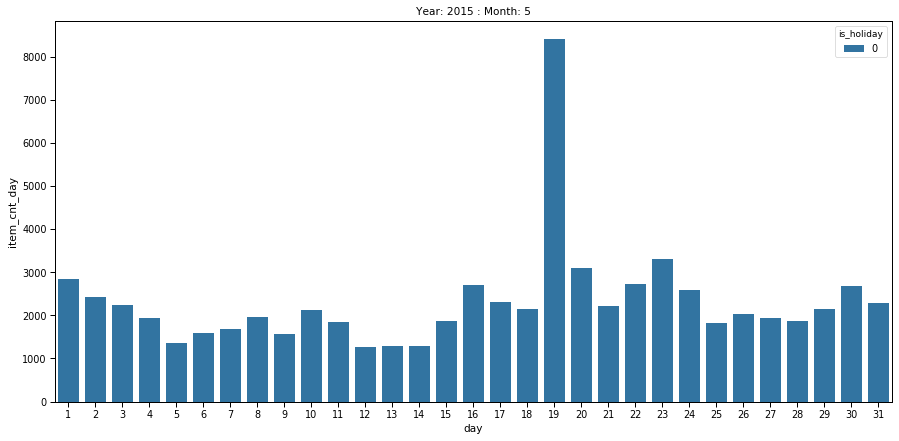

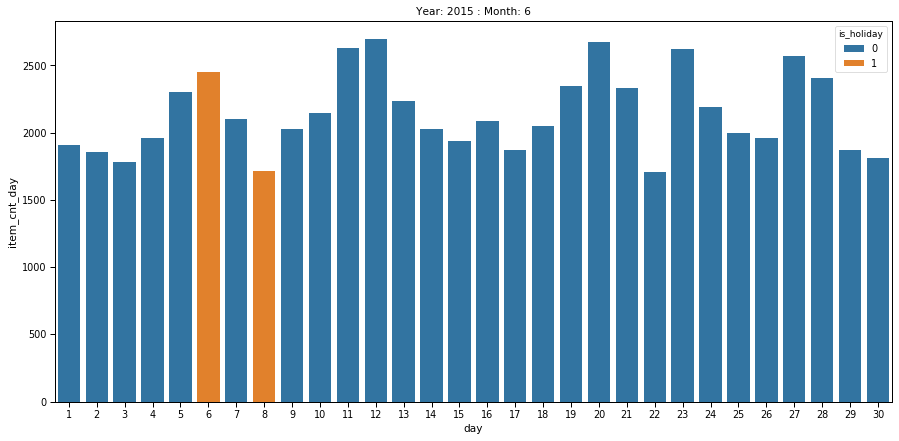

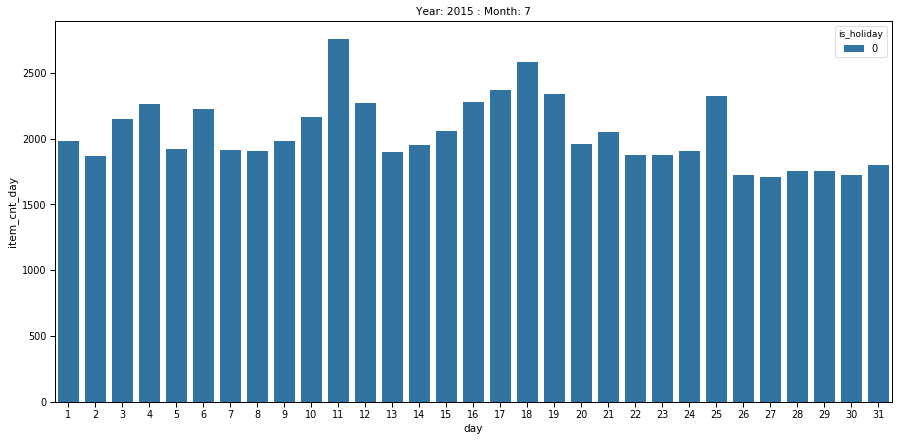

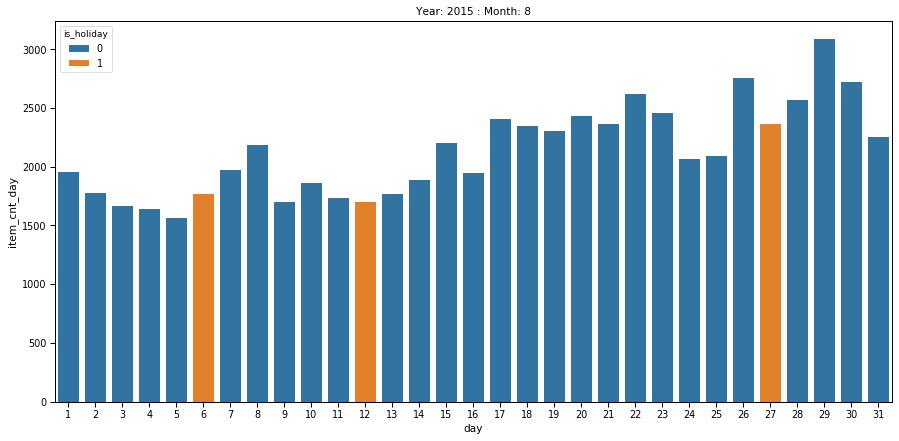

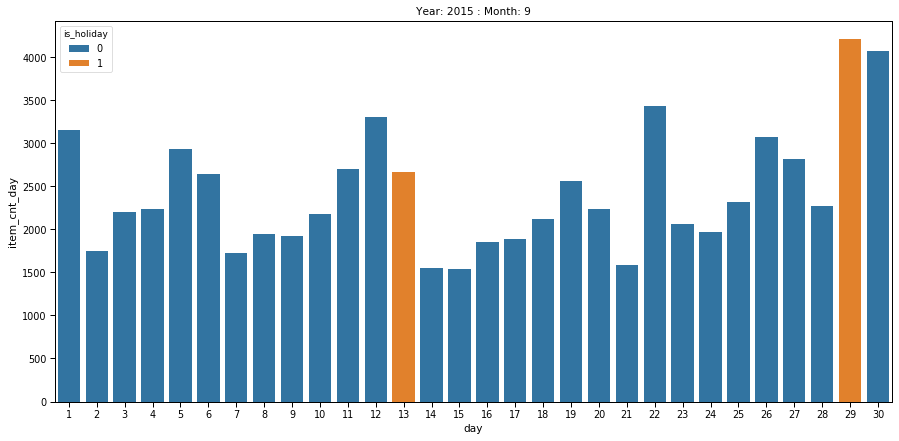

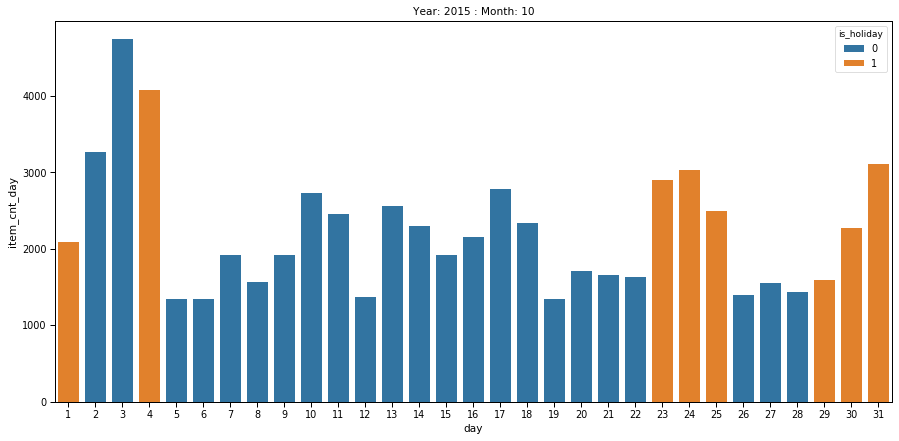

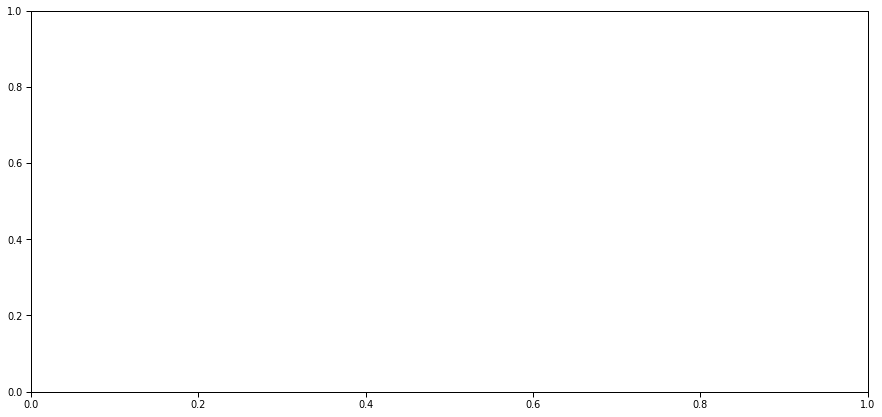

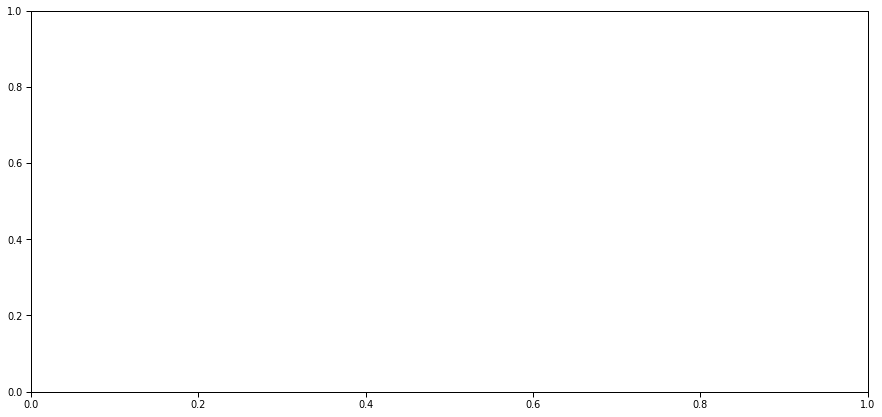

In [6]:
years = [2013,2014,2015]
for year in years:
    for month in range(1,13):
        sales_util.plot_sales_by_day(year,month,df_sales)

Our Data analysis reveal that public holiday aren't playing any major part in these plots. 

Rather the weekends (saturday, sunday) there is high sales. This clearly shows in almost all plots

Our strategy would be to count the Saturday and Sunday by month-year as follow:
- num_saturdays
- num_sundays

hopefully, the regression algorithm would be able to understand the pattern from it and it will be helpful in 
correctly identifying the future sale predictions.

In [7]:
df_sales[(df_sales['month']==7) & (df_sales['year']==2013) & (df_sales['day'].isin([7,13,20,27]))]['weekday'].unique()

array(['Sunday', 'Saturday'], dtype=object)

### 3. Checking for Weekend Trends, for all years

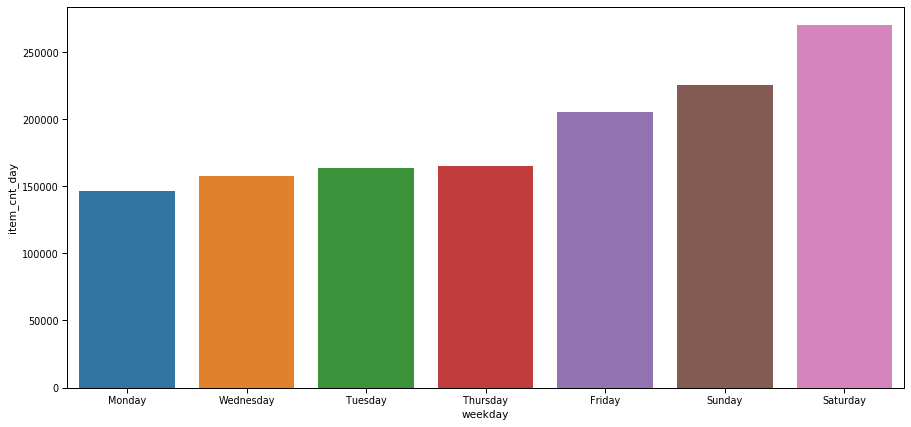

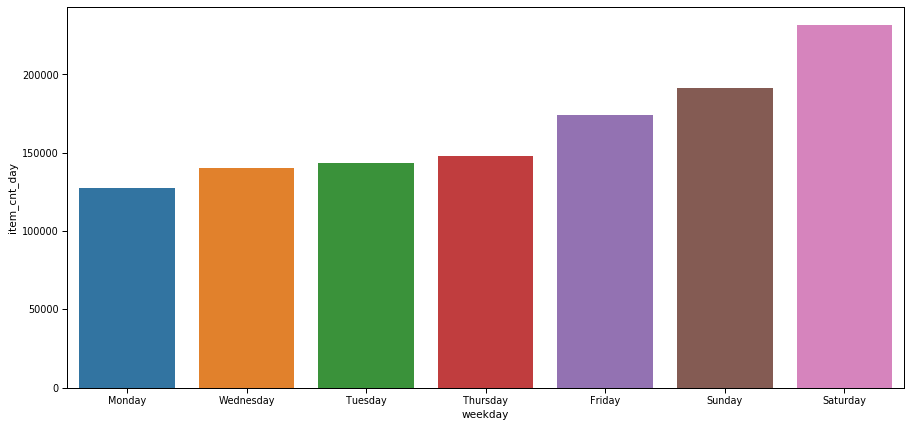

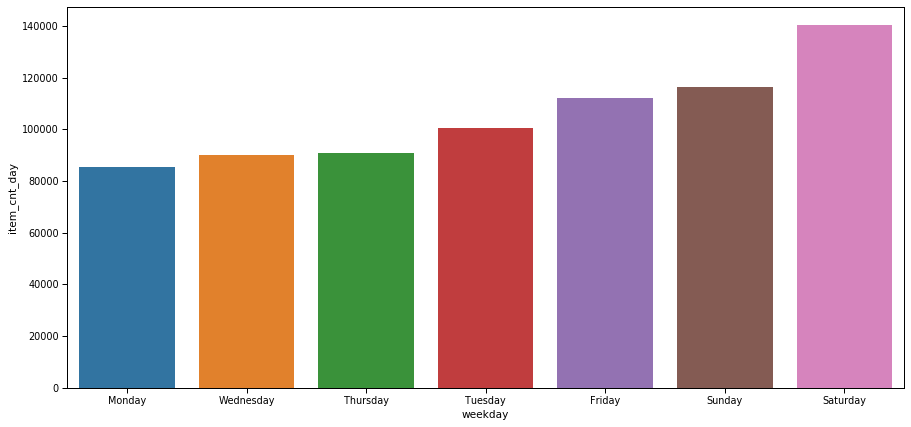

In [8]:
for year in years:
    sales_util.plot_sales_by_weekday(year,df_sales)

### 5. Checking for Cities Performance
In this analysis, we will try to figure out whether the top performing shops are in the top performing cities?

no
<class 'pandas.core.frame.DataFrame'>
top 5 cities are : [10 28 27 20 23]


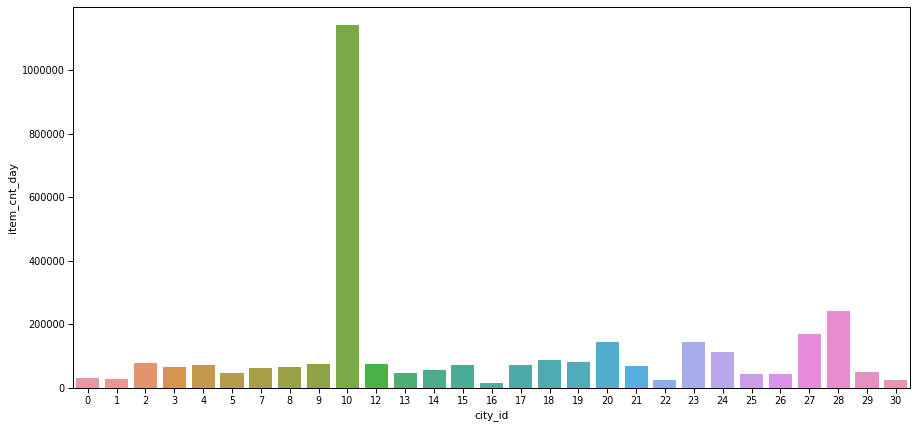

In [9]:
sales_util.plot_sales_by_x('city_id',0,df_sales)

<class 'pandas.core.frame.DataFrame'>
top 5 cities are : [10 28 27 23 20]
<class 'pandas.core.frame.DataFrame'>
top 5 cities are : [10 28 27 20 23]
<class 'pandas.core.frame.DataFrame'>
top 5 cities are : [10 28 20 27  3]


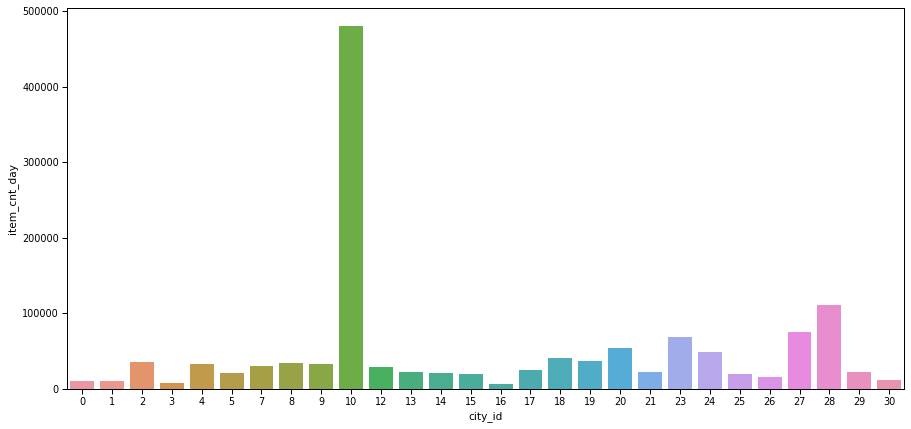

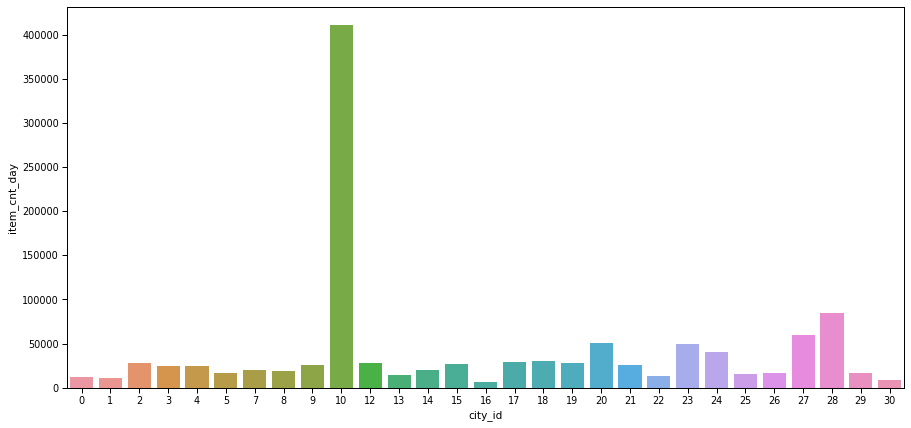

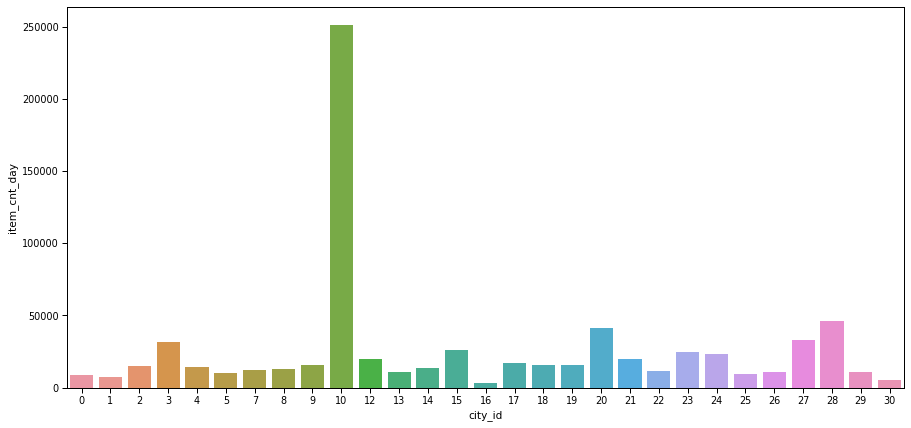

In [10]:
years = [2013,2014,2015]
for year in years:
    sales_util.plot_sales_by_x('city_id',year,df_sales)

So, 10,28,27,23,20 are the cities id which are top performing. let's see their names

In [11]:
df_sales[df_sales.city_id.isin([10,28,27,23,20])][['city_id','city_name']].drop_duplicates().reset_index(drop=True)

,city_id,city_name
0,10,Moscow
1,27,Voronezh
2,20,St.Petersburg
3,23,Tyumen
4,28,Yakutsk


### 6. Count the number of Days, Saturdays and Sundays in each month
We will create a data set with following columns
- date_block_num
- num_saturday
- num_sunday
- num_days

and later merge it with the grouped_by_month records

In [12]:
import calendar
from datetime import datetime

date_block_counter = 0
dbn = []
num_sat = []
num_sun = []
num_days = []

for year in years:
    for month in range(1,13):
        
        #addup the date block num
        dbn.append(date_block_counter)
        
        #count saturday
        num_sat.append(len([1 for i in calendar.monthcalendar(year,month) if i[calendar.SATURDAY] != 0]))
        
        #count sunday
        num_sun.append(len([1 for i in calendar.monthcalendar(year,month) if i[calendar.SUNDAY] != 0]))
        
        #count total days
        num_days.append(calendar.monthrange(year,month)[1])
        
        if date_block_counter == 34:break;
        date_block_counter+=1
        

week_day_count = pd.DataFrame(np.c_[dbn,num_sat,num_sun,num_days], columns=['date_block_num','num_sat','num_sun','num_days'])

### 7. Group by month, block conversion (perday sales to be summed up to per month sales)

In [13]:
%%time
df_matrix = sales_util.get_matrix_by_block(df_sales)


Wall time: 1min 13s


In [14]:
df_matrix.columns

Index(['shop_id', 'item_id', 'date_block_num', 'month', 'target', 'revenue',
       'target_shop', 'revenue_shop', 'target_item', 'revenue_item'],
      dtype='object')

In [15]:
df_sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,weekday,weekdayno,year,item_category_id,parent_cat_id,parent_cat,city_id,city_name,is_holiday,revenue
0,2013-01-02,0,59,22154,999.0,1,2,1,Wednesday,2,2013,37,6,cinema,29,Yaroslavl,0,999.0
1,2013-05-16,4,59,2573,249.0,1,16,5,Thursday,3,2013,55,13,music,29,Yaroslavl,0,249.0
2,2013-01-26,0,59,2574,399.0,1,26,1,Saturday,5,2013,55,13,music,29,Yaroslavl,0,399.0
3,2013-01-09,0,59,2574,399.0,1,9,1,Wednesday,2,2013,55,13,music,29,Yaroslavl,0,399.0
4,2013-02-24,1,59,2574,399.0,1,24,2,Sunday,6,2013,55,13,music,29,Yaroslavl,0,399.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588871,2015-10-28,33,55,1819,1499.0,3,28,10,Wednesday,2,2015,31,15,pc games,3,Digital,0,4497.0
2588872,2015-10-29,33,55,1819,1499.0,1,29,10,Thursday,3,2015,31,15,pc games,3,Digital,1,1499.0
2588873,2015-10-24,33,55,2390,99.0,1,24,10,Saturday,5,2015,31,15,pc games,3,Digital,1,99.0
2588874,2015-10-01,33,55,1935,249.0,1,1,10,Thursday,3,2015,31,15,pc games,3,Digital,1,249.0


In [16]:
df_sales = df_matrix.copy()

In [17]:
len_sales, len(df_sales)

(2588876, 9236152)

In [18]:
%%time
# merging with the items, item_categories, shops
df_sales = sales_util.merge_sales_n_shops(DATA_FOLDER,df_sales)

Wall time: 14.9 s


In [19]:
df_sales.head()

,shop_id,item_id,date_block_num,month,target,revenue,target_shop,revenue_shop,target_item,revenue_item,item_category_id,parent_cat_id,parent_cat,city_id,city_name
0,2,19,0,1,0.0,0.0,1151,1091137.01,1,28.0,40,6,cinema,0,Adygea
1,2,27,0,1,1.0,2499.0,1151,1091137.01,7,16275.0,19,9,games,0,Adygea
2,2,27,1,2,0.0,0.0,489,523629.00,3,5994.0,19,9,games,0,Adygea
3,2,27,2,3,0.0,0.0,756,734847.00,3,5994.0,19,9,games,0,Adygea
4,2,27,3,4,0.0,0.0,585,615909.00,1,1998.0,19,9,games,0,Adygea


### 8. Concatenating both test and train

In [20]:
%%time
dfmain = pd.concat([df_sales, df_test], axis=0)
dfmain = dfmain.drop(columns = ['ID'])
dfmain.fillna(0,inplace=True)
#dfmain.to_csv(os.path.join(DATA_FOLDER, 'sales_by_month_with_test.csv'), index=False)

Wall time: 10.1 s


In [21]:
len_sales, len(df_sales), len(dfmain)

(2588876, 9236152, 9450352)

### 9. Merging with the Num_Weekends dataset

In [22]:
dfmain = dfmain.merge(week_day_count[['date_block_num','num_sun','num_days']], how='inner')
del week_day_count, df_sales
gc.collect()

22934

### 10. Adding the Means

In [23]:
'''
#adding the mean attributes

1: expanding mean by shop id
2: shop/item target mean
3: item id target mean
4: month target mean
5: parent cat target mean
6: item category target mean
7: shop id target mean
8: city id target mean
9: shop_city target mean

'''
means_to_be_used = [1,4,6,7,8,9]
dfmain = sales_util.add_mean_features(dfmain, means_to_be_used)
gc.collect()

13

In [24]:
dfmain.tail()

,shop_id,item_id,date_block_num,month,target,revenue,target_shop,revenue_shop,target_item,revenue_item,...,num_days,shop_id_exp_y_mean,month_mean_target,item_cat_mean_target,item_cat_db_mean_target,shop_id_mean_target,shop_id_db_mean_target,city_id_mean_target,city_db_mean_target,shop_city_mean
9450347,45,18454,34,11,0.0,0.0,0.0,0.0,0.0,0.0,...,30,0.182247,0.278691,0.225766,0.0,0.182243,0.0,0.188977,0.0,0.182243
9450348,45,16188,34,11,0.0,0.0,0.0,0.0,0.0,0.0,...,30,0.182246,0.278691,0.297512,0.0,0.182243,0.0,0.188977,0.0,0.182243
9450349,45,15757,34,11,0.0,0.0,0.0,0.0,0.0,0.0,...,30,0.182245,0.278691,0.225766,0.0,0.182243,0.0,0.188977,0.0,0.182243
9450350,45,19648,34,11,0.0,0.0,0.0,0.0,0.0,0.0,...,30,0.182245,0.278691,0.259473,0.0,0.182243,0.0,0.188977,0.0,0.182243
9450351,45,969,34,11,0.0,0.0,0.0,0.0,0.0,0.0,...,30,0.182244,0.278691,0.182959,0.0,0.182243,0.0,0.188977,0.0,0.182243


### 11. Saving for the Last Time by the name of 

In [25]:
dfmain.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9450352 entries, 0 to 9450351
Data columns (total 26 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   shop_id                  int64  
 1   item_id                  int64  
 2   date_block_num           int64  
 3   month                    int64  
 4   target                   float64
 5   revenue                  float64
 6   target_shop              float64
 7   revenue_shop             float64
 8   target_item              float64
 9   revenue_item             float64
 10  item_category_id         int64  
 11  parent_cat_id            int64  
 12  parent_cat               object 
 13  city_id                  int64  
 14  city_name                object 
 15  num_sun                  int32  
 16  num_days                 int32  
 17  shop_id_exp_y_mean       float64
 18  month_mean_target        float64
 19  item_cat_mean_target     float64
 20  item_cat_db_mean_target  float64
 21  shop_id_

In [26]:
# columns where the mean has been added, are to be deleted, or useless columns like parent_cat etc.
#cols_to_delete = ['parent_cat','parent_cat_id','city_name','month','city_id','item_category_id']
cols_to_delete = ['parent_cat','city_name']
for col in cols_to_delete:
    dfmain.drop([col], axis=1, inplace=True)

In [27]:
dfmain['date_block_num'] = dfmain['date_block_num'].astype('int8')
dfmain['shop_id'] = dfmain['shop_id'].astype('int8')
dfmain['item_id'] = dfmain['item_id'].astype('int16')
dfmain['num_sun'] = dfmain['num_sun'].astype('int8')
dfmain['target'] = dfmain['target'].astype('float16')
dfmain['target_shop'] = dfmain['target_shop'].astype('float16')
dfmain['target_item'] = dfmain['target_item'].astype('float16')
dfmain['month'] = dfmain['month'].astype('int8')
dfmain['item_category_id'] = dfmain['item_category_id'].astype('int8')
dfmain['parent_cat_id'] = dfmain['parent_cat_id'].astype('int8')
dfmain['city_id'] = dfmain['city_id'].astype('int8')
dfmain['num_days'] = dfmain['num_days'].astype('int8')

# getting the mean attributes
mean_enc_cols = [col for col in dfmain.columns if 'mean' in str(col)]
for col in mean_enc_cols:
    dfmain[col] = dfmain[col].astype('float16')
    
# getting the mean attributes
revenue_cols = [col for col in dfmain.columns if 'revenue' in str(col)]
for col in revenue_cols:
    dfmain[col] = dfmain[col].astype('float32')

In [28]:
dfmain.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9450352 entries, 0 to 9450351
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   shop_id                  int8   
 1   item_id                  int16  
 2   date_block_num           int8   
 3   month                    int8   
 4   target                   float16
 5   revenue                  float32
 6   target_shop              float16
 7   revenue_shop             float32
 8   target_item              float16
 9   revenue_item             float32
 10  item_category_id         int8   
 11  parent_cat_id            int8   
 12  city_id                  int8   
 13  num_sun                  int8   
 14  num_days                 int8   
 15  shop_id_exp_y_mean       float16
 16  month_mean_target        float16
 17  item_cat_mean_target     float16
 18  item_cat_db_mean_target  float16
 19  shop_id_mean_target      float16
 20  shop_id_db_mean_target   float16
 21  city_id_

In [29]:
# deleting the records fo 2013
dfmain = dfmain[dfmain['date_block_num']>11]

In [30]:
dfmain.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5818986 entries, 3631366 to 9450351
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   shop_id                  int8   
 1   item_id                  int16  
 2   date_block_num           int8   
 3   month                    int8   
 4   target                   float16
 5   revenue                  float32
 6   target_shop              float16
 7   revenue_shop             float32
 8   target_item              float16
 9   revenue_item             float32
 10  item_category_id         int8   
 11  parent_cat_id            int8   
 12  city_id                  int8   
 13  num_sun                  int8   
 14  num_days                 int8   
 15  shop_id_exp_y_mean       float16
 16  month_mean_target        float16
 17  item_cat_mean_target     float16
 18  item_cat_db_mean_target  float16
 19  shop_id_mean_target      float16
 20  shop_id_db_mean_target   float16
 21  ci

### 12. Adding Lags

In [31]:
t = mean_enc_cols
dftmp = dfmain[t + ['shop_id','item_id','date_block_num']]

In [32]:
dftmp.columns

Index(['shop_id_exp_y_mean', 'month_mean_target', 'item_cat_mean_target',
       'item_cat_db_mean_target', 'shop_id_mean_target',
       'shop_id_db_mean_target', 'city_id_mean_target', 'city_db_mean_target',
       'shop_city_mean', 'shop_id', 'item_id', 'date_block_num'],
      dtype='object')

In [33]:
t

['shop_id_exp_y_mean',
 'month_mean_target',
 'item_cat_mean_target',
 'item_cat_db_mean_target',
 'shop_id_mean_target',
 'shop_id_db_mean_target',
 'city_id_mean_target',
 'city_db_mean_target',
 'shop_city_mean']

In [34]:
dfmain.drop(t,axis=1, inplace=True)

In [35]:
dfmain.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5818986 entries, 3631366 to 9450351
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   shop_id           int8   
 1   item_id           int16  
 2   date_block_num    int8   
 3   month             int8   
 4   target            float16
 5   revenue           float32
 6   target_shop       float16
 7   revenue_shop      float32
 8   target_item       float16
 9   revenue_item      float32
 10  item_category_id  int8   
 11  parent_cat_id     int8   
 12  city_id           int8   
 13  num_sun           int8   
 14  num_days          int8   
dtypes: float16(3), float32(3), int16(1), int8(8)
memory usage: 199.8 MB


In [36]:
len(dftmp), len(dfmain)

(5818986, 5818986)

In [37]:
#adding lags
#shift_range = [1,2,3,11,12] feature importance, 11 and 12 not important.
shift_range = [1,2,3,11,12]
# additional columns, not to be counted when calculating lags
except_cols = ['num_days','num_sun','city_id','parent_cat_id','item_category_id','month'] 

In [38]:
except_cols

['num_days',
 'num_sun',
 'city_id',
 'parent_cat_id',
 'item_category_id',
 'month']

In [39]:
%%time
dfmain = sales_util.add_lags(dfmain, shift_range, except_cols)


Wall time: 1min 23s


In [40]:
len(dftmp), len(dfmain)

(5818986, 5818986)

In [41]:
dfmain.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5818986 entries, 0 to 5818985
Data columns (total 45 columns):
 #   Column               Dtype  
---  ------               -----  
 0   shop_id              int8   
 1   item_id              int16  
 2   date_block_num       int8   
 3   month                int8   
 4   target               float16
 5   revenue              float32
 6   target_shop          float16
 7   revenue_shop         float32
 8   target_item          float16
 9   revenue_item         float32
 10  item_category_id     int8   
 11  parent_cat_id        int8   
 12  city_id              int8   
 13  num_sun              int8   
 14  num_days             int8   
 15  revenue_lag_1        float32
 16  revenue_item_lag_1   float32
 17  revenue_shop_lag_1   float32
 18  target_lag_1         float16
 19  target_item_lag_1    float16
 20  target_shop_lag_1    float16
 21  revenue_lag_2        float32
 22  revenue_item_lag_2   float32
 23  revenue_shop_lag_2   float32
 24

In [42]:
len(dfmain), len(dftmp)

(5818986, 5818986)

In [43]:
dfmain = dfmain.merge(dftmp, how='inner', on=['shop_id','item_id','date_block_num'])

In [44]:
len(dfmain), len(dftmp)

(5818986, 5818986)

In [45]:
del dftmp

In [46]:
dfmain.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5818986 entries, 0 to 5818985
Data columns (total 54 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   shop_id                  int8   
 1   item_id                  int16  
 2   date_block_num           int8   
 3   month                    int8   
 4   target                   float16
 5   revenue                  float32
 6   target_shop              float16
 7   revenue_shop             float32
 8   target_item              float16
 9   revenue_item             float32
 10  item_category_id         int8   
 11  parent_cat_id            int8   
 12  city_id                  int8   
 13  num_sun                  int8   
 14  num_days                 int8   
 15  revenue_lag_1            float32
 16  revenue_item_lag_1       float32
 17  revenue_shop_lag_1       float32
 18  target_lag_1             float16
 19  target_item_lag_1        float16
 20  target_shop_lag_1        float16
 21  revenue_

In [47]:
dfmain.to_csv(os.path.join(DATA_FOLDER, 'df_main_with_test.csv'), index=False)